# Week 3: Firm Growth Dynamics

This week's tutorial focuses on simulating firm growth, starting with the Kesten Model and then moving to simulating firm growth with a target size.

You will learn to write basic Python loops and functions. Then we introduce numpy to speed up the code and use matrix operations.


## Section 1: The Kesten Model

The Kesten Model is a stochastic model that can be used to describe the growth of firms. It is defined by the recursive equation:

$$x_{t+1} = x_{t} b_{t} + a_{t},$$

where $x_{t}$ represents the firm's size at time $t$, $b_{t}>0$ is a random variable representing firm's growth rate, and $a_{t}>0$ is a base growth rate (which we assume to be constant).

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt # for plotting
import random # for random number generation (built-in, not numpy)
import numpy as np

#### Task 1: Write a function that simulates the Kesten Model

In [3]:
np.random.seed(2)

def kesten_process(steps, mu=1, sigma=0.2):
    x_seq = [1.0]
    a = 0.1
    for i in range(steps):
        b = np.random.normal(mu,sigma)
        x_seq.append(b*x_seq[-1]+a)

    return x_seq

#### Task 2: Simulate the Kesten Model for 1000 periods and 10_000 firms

In [4]:
n_firms = 10_000
n_steps = 1_000

# YOU CODE HERE 
kesten_model = []
for i in range(n_firms):
    kesten_model.append(kesten_process(n_steps, sigma=0.1))

#### Task 3: Plot some trajectories of firm growth and the distribution of firm sizes

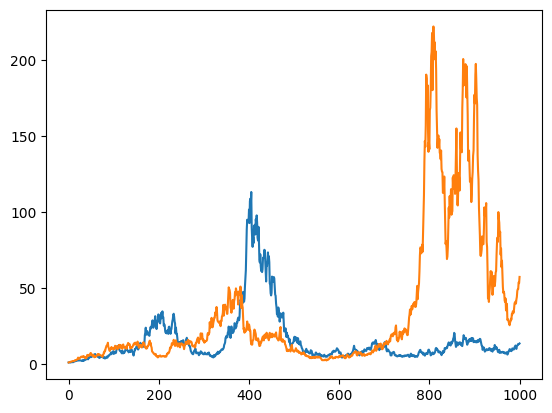

In [5]:
# lets plot the first 2 sequences
# YOU CODE HERE 
plt.plot(kesten_model[0])
plt.plot(kesten_model[1])
plt.show()

Log mean: 3.283670109413997


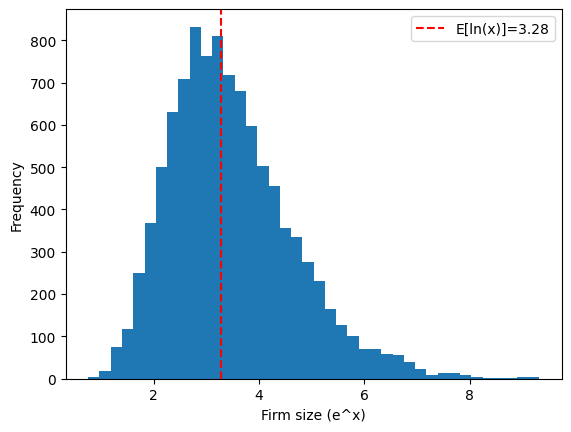

In [104]:
from statistics import geometric_mean

# plot the size distribution using log sized bins
final_sizes = [agent_seq[-1] for agent_seq in kesten_model]
log_final_sizes = np.log(final_sizes)
log_mean = geometric_mean(log_final_sizes)
print("Log mean:",  log_mean)
plt.hist(np.log(final_sizes), bins=40)
plt.axvline(log_mean, color='r', linestyle='--', label="E[ln(x)]={:.2f}".format(log_mean))
# plt.xscale("log")
plt.xlabel("Firm size (e^x)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Playing around with mean values

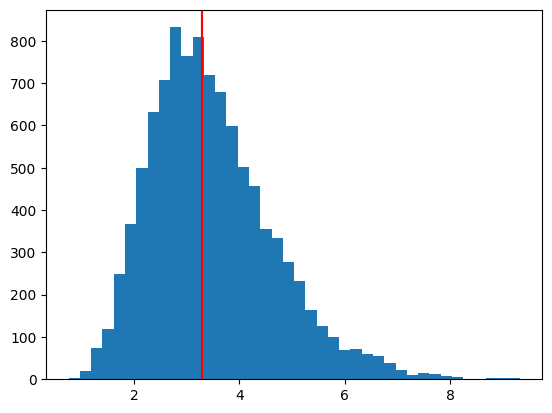

Mean without std: 3.283670109413997
True mean? :  3.283670109413997
1.174337457285806


In [112]:
mean = np.exp(log_mean)
plt.figure()
plt.hist(np.log(final_sizes), bins=40)
# plt.xscale("log")
plt.axvline(np.log(mean), color='r', linestyle='-')
plt.axvline(geometric_mean(np.log(final_sizes)), color='r', linestyle='-')
plt.show()
print("Mean without std:", np.log(mean))
print("True mean? : ", geometric_mean(np.log(final_sizes)))

log_std = np.std(log_final_sizes)
print(log_std)


## Section 2: Numpy Vectorization

Numpy is the foundation of scientific computing in Python, enabling operations across arrays simultaneously and eliminating (mostly) the need for explicit loops.

This feature is especially useful in this exercise. Since this growht process is an example of an [Embarrassingly Parallel Task](https://en.wikipedia.org/wiki/Embarrassingly_parallel).

This is because we can simulate the growth of multiple firms at the same time, as one firm's growth does not affect another's.

To leverage numpy's vectorization, we need to rewrite the Kesten Model as matrix operations.

#### Task 1: Simulate the Kesten Model for 1000 periods and 10_000 firms using numpy and plot the distribution of firm sizes

In [113]:
np.random.seed(2)
n_time = 1_000
n_firms = 10_000

# Matrix Definition
a = 0.1
A = np.ones((n_firms, n_time))*a # YOU CODE HERE
B = np.random.normal(1,0.1, (n_firms, n_time)) # YOU CODE HERE
sequences = np.ones((n_firms, n_time)) # YOU CODE HERE
# zeros = np.zeros((n_firms, 1))
# B_cumsums = B[:,1:].cumsum(axis=1)
# B_cumsums = np.hstack((zeros, B_cumsums))
# B_cumprods = B.cumprod(axis=1)
# sequences = B_cumprods+a*B_cumsums
# print(B_cumprods[3])
# print(B_cumprods.shape)

# YOU CODE HERE
print(sequences.shape)
for i in range(n_time):
    sequences[:, i] = sequences[:,i-1]*B[:,i]+a
# B_cumprods = np.cumprod(B, axis=1) 
# sequences = B_cumprods+A*B_cumsums

(10000, 1000)


3.283670109413997


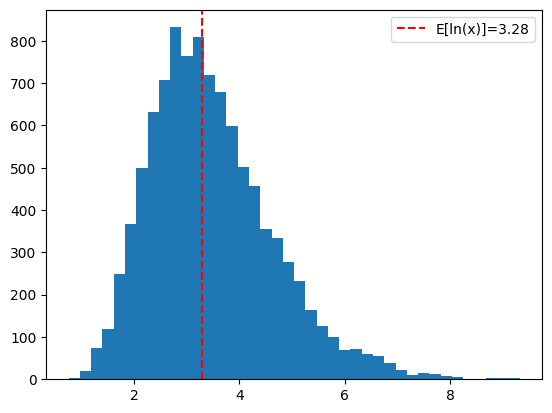

In [115]:
# plot the histogram
# YOU CODE HERE
vector_log_mean = geometric_mean(np.log(sequences[:,-1]))
print(vector_log_mean)
plt.hist(np.log(sequences[:,-1]), bins=40)
# plt.xscale("log")
plt.axvline(log_mean, color='r', linestyle='--', label="E[ln(x)]={:.2f}".format(vector_log_mean))
plt.legend()
plt.show()

## Section 3: Simulating Growth Towards a Target Size

This section explores a model where firms grow towards a target size, $x^*$, expanding when they are below the target and contracting when they are above it.

The size of a firm at $t+1$, $x_{t+1}$, is given by the following equation:

\begin{align*}
  x_{t+1}= x_t \cdot \epsilon_t \cdot \left\{
  \begin{array}{ll}
    k, & \text{if } x_t \leq x^* \quad \text{(Expansion)}\\
    \frac{1}{k}, & \text{if } x_t > x^* \quad \text{(Contraction)}
  \end{array} \right.
\end{align*}

The growth rate, denoted by $\epsilon_t$, is adjusted by a scaling factor $k>1$, modifying the growth rate based on the firm's current size.


In this example, $\epsilon_t$ is a growth rate sampled from an iid log-normal distribution.


#### Task 1: Simulate growth with Numpy

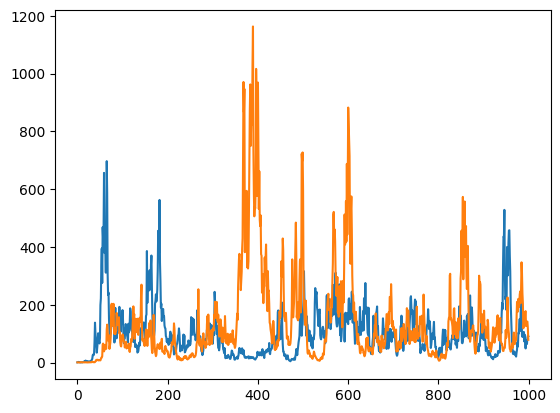

In [146]:
# Set the target size for firm growth
target_size = 100
k = 1.05

# Generate a matrix E with log-normal growth rates for each agent at each time step (mean=0, std=0.3)
mu = 0
sigma = 0.3
E = np.random.lognormal(mu, sigma, (n_firms, n_steps))

# Set the growth factor (k) used when a firm's size is smaller than the target size
def growth_factor(k, x, target_size = target_size):
    smaller_or_bigger = x<target_size
    growth_factors = np.where(smaller_or_bigger, k, 1/k)
    return growth_factors

# Initialize the current size (x0) of each agent to 1
x0 = np.ones(n_firms)

# Initialize a matrix to store size of each firm at each time step
size_matrix = np.ones((n_firms, n_steps))

# Simulate the growth process over time
for t in range(n_steps):
    # YOU CODE HERE
    size_matrix[:, t] = size_matrix[:, t-1]*E[:, t] * growth_factor(k, size_matrix[:, t-1])

plt.plot(size_matrix[0])
plt.plot(size_matrix[1])
plt.show()

#### Task 2: Plot the Distribution of Log-Rates

Unlike the Kesten process, the growth rates in this scenario are not iid; specifically, they are not independent. This dependency arises because the next growth rate could be either $k \epsilon_t$ or $\frac{\epsilon_t}{k}$, depending on $x_t$.

In the Kesten process (above), the distribution of growth rates was predetermined, and therefore, we did not investigate its distribution. However, in this case, the distribution of growth rates is unknown a priori.

To determine the distribution of growth rates, we define $r_t = \ln(\frac{x_{t+\tau}}{x_t})$, extracting these values from the simulation at each firm and timestep. Notice the logarithm to obtain log-growth.

Note that $\tau$ represents the time lag, which we will set to $\tau=1$.

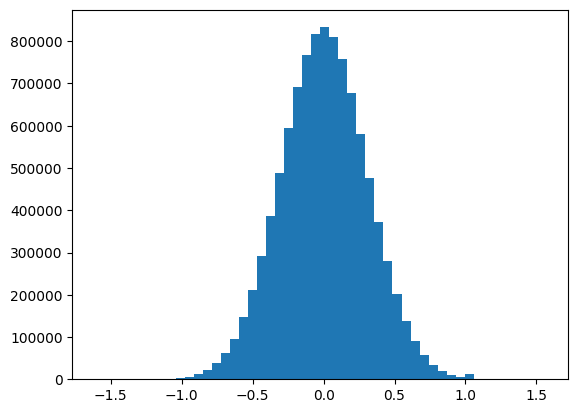

In [147]:
# Plot the size distribution at the end of the simulation
from scipy import stats

tau = 1

growth_rates = np.ones((n_firms, n_time))

for i in range(n_time-tau):
    growth_rates[:, i] = np.log(size_matrix[:, i+tau] / size_matrix[:, i])

empirical_mean = growth_rates.flatten().mean()
empirical_std = growth_rates.flatten().std()
x = np.linspace(empirical_mean-3*empirical_std, empirical_mean+3*empirical_std, 100)
y = stats.laplace.pdf(x, loc=empirical_mean, scale=empirical_std)

plt.hist(growth_rates.flatten(), bins=50)
plt.show()

### Side-by-side histograms for different parameter combinations

<Figure size 1800x1200 with 0 Axes>

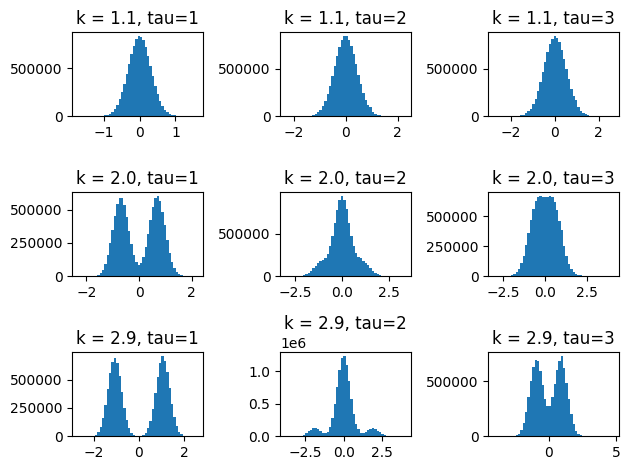

In [141]:
growth_rates_plot = np.ones((n_firms, n_time))

plt.figure(figsize=(18,12))
fig, axs = plt.subplots(3, 3)
for i in range(3): # Vary k
    k = 1.1+i*0.9
    size_matrix_plot = np.ones((n_firms, n_steps))
    
    # Generate correct histogram data for tau
    for t in range(n_steps):
        size_matrix_plot[:, t] = size_matrix_plot[:, t-1]*E[:, t] * growth_factor(k, size_matrix_plot[:, t-1])
    
    for j in range(3): # Vary Tau
        tau = 1+j
        growth_rates_plot = np.ones((n_firms, n_time))
        
        # Generate correct histogram data for k and tau
        for l in range(n_time-tau):
            growth_rates_plot[:, l] = np.log(size_matrix_plot[:, l+tau] / size_matrix_plot[:, l])

        #Plot subplot (i,j)
        axs[i, j].hist(growth_rates_plot.flatten(), bins=50)
        axs[i, j].set_title(f"k = {round(k,2)}, tau={tau}")
        # axs[i, j].set_yscale("log")

# for ax in fig.get_axes():
#     ax.label_outer()
fig.tight_layout()
plt.show()


**Questions:**

1. What distribution do the log-returns follow? 
   1. For small $k$, the log-return distribution looks very normal for most values of $\tau$, in other words, the underlying return distribution is lognormal
2. How does the distribution of log-returns change as $\tau$ increases?
   1. The width increases, so the variance is bigger in the distribution for larger values of $\tau$ which intuitively makes sense as it's a bigger time interval for a firm to either grow or shrink on. I think it is more because of the initial growth phase before hitting the oscillating area around the target size, as in the oscillating phase the growth rate over a larger time interval should stabilize back to 1.
3. Set $k$ to a high number, e.g., 3, and observe the distribution of log-returns for different $\tau$ values. What do you observe? Why is this?
   1. For a larger $k$ we see similarities with the mixture model where we sample from two normal distributions with different means. This also makes sense, as they are symmetrical over 0 meaning these two distributions are from the growth or decline phase because of us changing the growth rate between $k$ and $\frac{1}{k}$ depending if the current firm size is over or under the target size. <br><br> For larger values of $\tau$ it gets more interesting, and the result can be explained from $\tau$ being even or odd. When it is even, a firm has two step sizes to grow or shrink on. In the graph for $k=2.9$ and $\tau = 2$ we see two smaller bumps on either side of a 0-mean normal. The 0-centered mean can be explained by looking at the graph to the left with $\tau = 1$. A firm above the target size will shrink by a relative large $k$ which we have chosen, and will end up beneath the target size. In the next step the firm will grow by again a large $k$ and end up on e.g. the same size having a resulting growth rate of $1$ over $2$ steps. For $\tau = 3$ we naturally see a similar shape as for $\tau=1$ because of being odd, but with both "normal distributions" having larger variance because of the larger step size.

#### Task 3: Plot firm size distribution

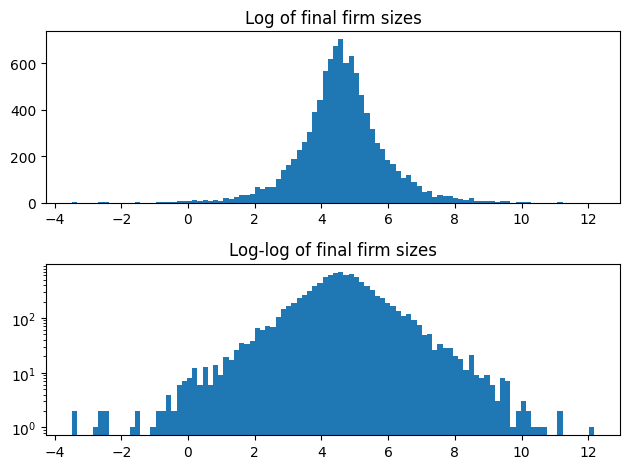

100.20847208218156
100


In [149]:
# plot size distribution in log-log scale
fig, (ax1, ax2) = plt.subplots(2)
ax1.hist(np.log(size_matrix[:, -1]), bins=100)
ax1.set_title("Log of final firm sizes")
ax2.hist(np.log(size_matrix[:, -1]), bins=100)
ax2.set_title("Log-log of final firm sizes")
ax2.set_yscale("log")
# ax2.set_xscale("log")
fig.tight_layout()
plt.show()

print(np.exp(np.log(size_matrix[:, -1]).mean()))
print(target_size)

**Questions:** Why does the firm size distribution not converge to a log-normal distribution? What assumption is violated?
- The growth rates are not independent anymore, they are dependent on the current $x_t$, and will then be either $k \epsilon_t$ or $\frac{\epsilon_t}{k}$

#### Task 4: Explicit Sampling of Growth Rates from a Laplace Distribution

In the previous exploration, growth rates derived from an implicitly Laplacian distribution were not iid, leading to a non-log-normal firm size distribution. 


**Questions:**  If we explicitly sample growth rates from a Laplace distribution, i.e., satisfying the iid assumption, what distribution of firm sizes should we now expect?


The growth process is defined as:
$$
x_{t+1} = x_t \times \lambda_i
$$

This can be equivalently expressed as:
$$
x_{t+1} = x_0 \times \prod_{i=1}^{t} \lambda_i
$$

Or in log form:
$$
\ln(x_{t+1}) = \ln(x_0) + \sum_{i=1}^{t} \ln(\lambda_i)
$$

Here, $\ln(\lambda_i)$ is sampled from a Laplace distribution with a mean of 0.1 and a scale of 0.4. Since $x_0 = 1$, $\ln(x_0)$ is zero and omitted.

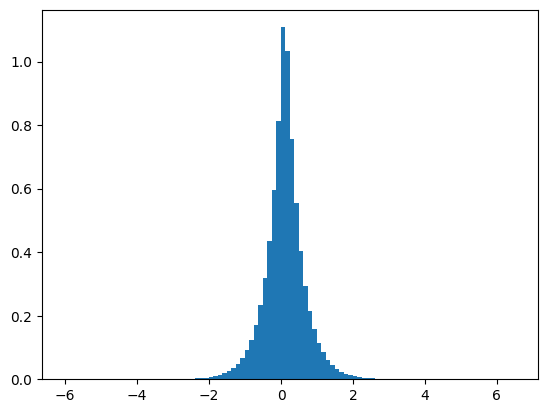

In [13]:
L = np.random.laplace(0.1, .4, (n_firms, n_time))
# show the distribution
plt.hist(L.flatten(), bins=100, density=True)

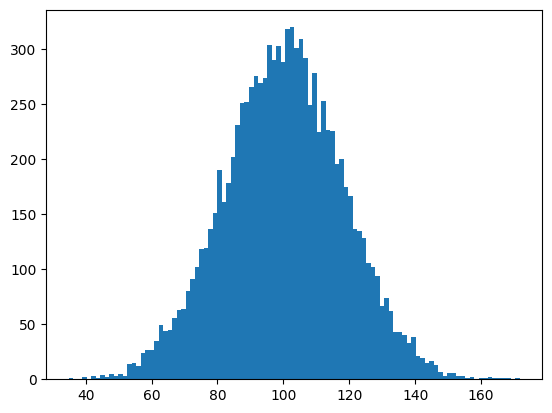

In [14]:
# show firm size distribution
plt.hist(L.sum(axis=1), 100)

Now it's kind of the other way around. The growth rates are laplace-distributed and the final firm sizes end up being (log)-normally distributed. On the other hand, in the previous task I ended up with the growth rates being drawn from a bimodal normal distribution and the final firm sizes ended up following a laplace distribution. But from the empirical evidence it should be the growth rates that are Laplacian and final firm sizes that are lognormal. So it looks like the explicit drawing is more in line with the empirical and my simulations of growth towards a target size have failed.